# Modelling per Country

##### Modelling by country, has great results over train data but very poorly over test data due to lack of data

## Import libraries

In [529]:
import pandas as pd, numpy as np, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

# Librerías para plots
from sklearn import tree
#import graphviz
from scipy.stats import norm
from scipy.stats import t
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Read file and prepare data 

In [544]:
#df = pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed.csv')
#df = pd.read_csv('/Users/lucas_botella/Downloads/cluster_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
#df=pd.read_csv('/Users/lucas_botella/Downloads/cluster_per_deaths_for_model.csv')
df=pd.read_csv('/Users/lucas_botella/Downloads/raw_deaths_covid_data.csv')
del df['Unnamed: 0']
#del df['life_expectancy']
#del df['average_deaths_2015_2019_all_ages']
#del df['month']
#del df['deaths_prev_18']
#del df['deaths']
#del df['0.0']
#del df['1.0']
#del df['2.0']
#del df['3.0']
#del df['4.0']
#df=df[df['cluster']==2]
#del df['cluster']
#df=df[df['Excess mortality P-scores, all ages Prev 18 days'] > 33]
del df['Excess mortality P-scores, all ages Prev 18 days']
del df['Excess mortality P-scores, all ages']

df['deaths_prev_18']=df['deaths_prev_18']+df['average_deaths_2015_2019_all_ages']
df['deaths']=df['deaths']+df['average_deaths_2015_2019_all_ages']

df['R0']=df['deaths']/df['deaths_prev_18']
del df['deaths']
del df['average_deaths_2015_2019_all_ages']
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,month,deaths_prev_18,R0
0,AUS,2020-03-09,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3319.452250,0.988133
1,AUS,2020-03-16,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3267.869125,1.001339
2,AUS,2020-03-23,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3280.061500,0.997141
3,AUS,2020-03-30,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3272.245875,1.024936
4,AUS,2020-04-06,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4,2683.241450,1.071784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.224571,-9.775571,14.102286,-41.081571,-15.591714,-44.102000,1.0,3.0,...,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,1,104743.945988,0.969306
2078,USA,2021-01-25,-23.653143,-10.571429,12.591857,-40.000000,-20.244857,-34.122429,1.0,3.0,...,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,1,107476.332187,0.925112
2079,USA,2021-02-01,-24.387714,-11.836714,10.897857,-39.938714,-22.000000,-27.754857,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.307500,8.30,78.539024,2,79100.944980,0.947272
2080,USA,2021-02-08,-25.040857,-13.693857,10.816143,-40.816429,-17.673571,-29.857143,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.913333,8.30,78.539024,2,77463.855070,0.929953


In [545]:
df.sort_values('R0')

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,month,deaths_prev_18,R0
1329,LUX,2020-09-07,-25.285714,-17.632857,8.734714,-22.204143,118.983250,-42.112286,2.000000,3.000000,...,NaN,4.26,1054000.0,90.727,NaN,16.820000,82.295122,9,100.67930,0.593903
587,ECU,2020-05-04,-81.673429,-66.020429,35.918571,-80.224429,-76.816286,-76.938857,1.000000,2.000000,...,NaN,1.39,1418000.0,63.670,NaN,8.710000,76.800000,5,7020.04556,0.606663
642,ESP,2020-05-04,-90.653000,-56.306000,30.081714,-84.224429,-81.265429,-71.183571,1.000000,1.000000,...,5.87,2.97,75315000.0,80.080,NaN,32.610001,83.431707,5,20072.60091,0.626615
588,ECU,2020-05-11,-79.204000,-64.204143,34.244857,-78.795714,-74.550857,-73.448857,1.000000,2.000000,...,NaN,1.39,1418000.0,63.670,NaN,8.710000,76.800000,5,5411.63139,0.627814
130,BEL,2020-09-07,-13.408143,-9.775571,7.836714,-31.693857,89.510143,-32.387714,2.000000,2.000000,...,NaN,5.58,7481000.0,97.961,NaN,14.250000,81.595122,9,2918.96434,0.634173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,ESP,2020-04-13,-88.346714,-52.367429,28.020571,-82.204286,-80.632714,-65.734857,1.000000,1.000000,...,5.87,2.97,75315000.0,80.080,NaN,32.610001,83.431707,4,12196.05856,1.659007
109,BEL,2020-04-13,-76.061286,-27.551143,24.592000,-67.612143,-22.612286,-59.428571,1.000000,1.000000,...,NaN,5.58,7481000.0,97.961,NaN,14.250000,81.595122,4,2298.65680,1.721480
638,ESP,2020-04-06,-69.795857,-25.347143,19.387714,-61.571429,-57.755143,-45.285714,1.000000,1.000000,...,5.87,2.97,75315000.0,80.080,NaN,32.610001,83.431707,4,8717.78592,2.154215
583,ECU,2020-04-06,-42.836714,-18.285571,17.693857,-40.204143,-40.612286,-39.857143,0.857143,1.142857,...,NaN,1.39,1418000.0,63.670,NaN,8.710000,76.800000,4,1430.99697,2.626877


In [546]:
df.to_csv('/Users/lucas_botella/Downloads/hey.csv')

In [547]:
df

,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,contact_tracing,testing_policy,...,nurses_per_1000,beds_per_1000,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,life_expectancy,month,deaths_prev_18,R0
0,AUS,2020-03-09,0.844429,1.513714,-1.051571,6.238714,-1.572286,9.373571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3319.452250,0.988133
1,AUS,2020-03-16,0.979571,2.061143,-1.204286,8.938714,-0.102000,11.000000,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3267.869125,1.001339
2,AUS,2020-03-23,1.285714,7.040857,-0.816143,8.061143,-0.816286,10.183857,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3280.061500,0.997141
3,AUS,2020-03-30,-0.122286,10.122429,0.102000,2.061143,-1.755143,5.979571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,3,3272.245875,1.024936
4,AUS,2020-04-06,-4.489857,23.734571,2.449000,-11.000000,-12.081571,5.081571,2.0,1.0,...,11.92,3.84,8263000.0,85.904,NaN,11.84,82.748780,4,2683.241450,1.071784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,USA,2021-01-18,-25.224571,-9.775571,14.102286,-41.081571,-15.591714,-44.102000,1.0,3.0,...,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,1,104743.945988,0.969306
2078,USA,2021-01-25,-23.653143,-10.571429,12.591857,-40.000000,-20.244857,-34.122429,1.0,3.0,...,11.89,2.87,75608000.0,82.058,NaN,8.30,78.539024,1,107476.332187,0.925112
2079,USA,2021-02-01,-24.387714,-11.836714,10.897857,-39.938714,-22.000000,-27.754857,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.307500,8.30,78.539024,2,79100.944980,0.947272
2080,USA,2021-02-08,-25.040857,-13.693857,10.816143,-40.816429,-17.673571,-29.857143,1.0,3.0,...,11.89,2.87,75608000.0,82.058,0.913333,8.30,78.539024,2,77463.855070,0.929953


Text(0.5, 1.0, 'R0')

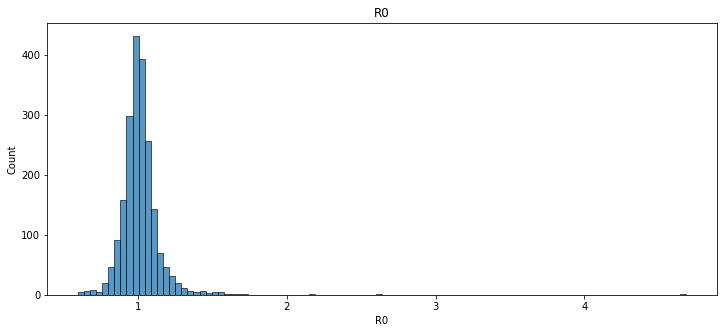

In [548]:
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='R0', data=df, kde=False, bins=100, ax=axes);
axes.set_title('R0')

In [549]:
df=df.fillna(df.median())

In [550]:
X=df[df.columns[2:-1]]
y=df['R0']

In [551]:
y

0       0.988133
1       1.001339
2       0.997141
3       1.024936
4       1.071784
          ...   
2077    0.969306
2078    0.925112
2079    0.947272
2080    0.929953
2081    0.927044
Name: R0, Length: 2082, dtype: float64

## Apply model and view results 

pip install xgboost

In [552]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

## XGBoost Regressor 

### GridSearchCV 

In [553]:
import warnings
warnings.filterwarnings('ignore')

In [554]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, verbose=1)

In [555]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

df_outliers.sort_values('y')

In [557]:
y_train

1299    0.860855
702     1.154176
553     0.960699
520     1.014313
1108    1.006481
          ...   
1593    0.963328
1147    1.030689
1766    1.003255
1122    1.108776
1346    0.909973
Name: R0, Length: 1665, dtype: float64

In [520]:
y_train

702     203.166227
553    -310.332103
520     -12.109745
1108    -13.190731
184     -72.252747
           ...    
96      104.662005
1761   -106.189213
1593   -144.029851
1122      2.631579
1346    -23.560802
Name: y, Length: 1328, dtype: float64

In [558]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  7.0min finished


CPU times: user 6min 50s, sys: 1.47 s, total: 6min 51s
Wall time: 7min 2s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [559]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [560]:
y_pred=grid.best_estimator_.predict(X_test)

## Model evaluation metrics

In [561]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.08911556664150769
mse score is 0.022718805337070557
rmse score is 0.15072758651643883
r2 score is -0.23357670577479261


In [562]:
y_pred_train=grid.best_estimator_.predict(X_train)

In [563]:
mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

for key in scores:
    print(f"{key} score is {scores[key]}")

mae score is 0.07060182090060643
mse score is 0.011116790977986186
rmse score is 0.1054361938709198
r2 score is 0.49999369740079747


In [564]:
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval['Difference']=np.abs(df_eval['Actual']-df_eval['Predicted'])
#df_eval=df_eval.sort_values('Difference')
df_eval.sort_values('Difference', ascending=False)

,Actual,Predicted,Difference
585,1.568013,3.148983,1.580969
638,2.154215,0.987636,1.166579
633,1.625013,1.041645,0.583368
108,1.502079,1.036077,0.466003
803,1.392315,0.969356,0.422959
...,...,...,...
119,0.992728,0.991520,0.001209
811,0.995397,0.996211,0.000814
735,0.968559,0.968233,0.000326
224,0.987214,0.987449,0.000235


## Model evaluation plots

Text(0.5, 1.0, 'Difference Histogram')

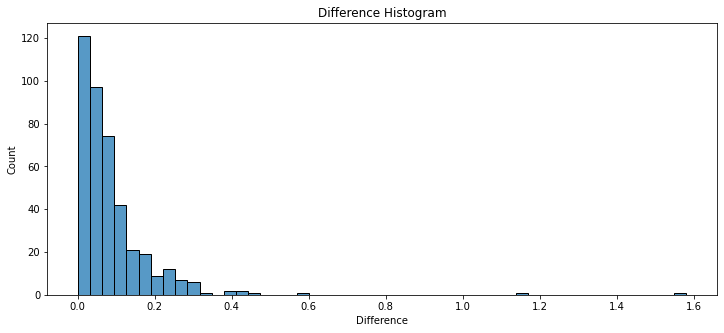

In [565]:
# plot difference hist
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='Difference', data=df_eval, kde=False, bins=50, ax=axes);
axes.set_title('Difference Histogram')

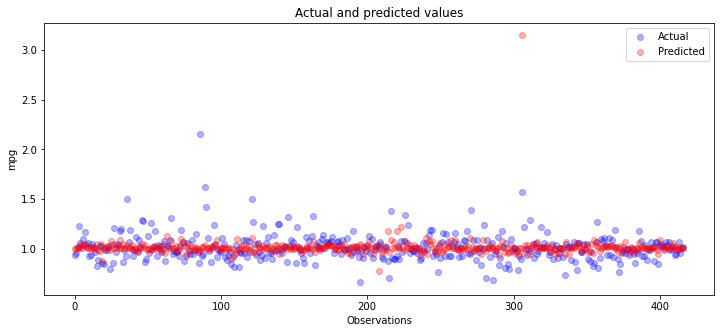

In [566]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12,5))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

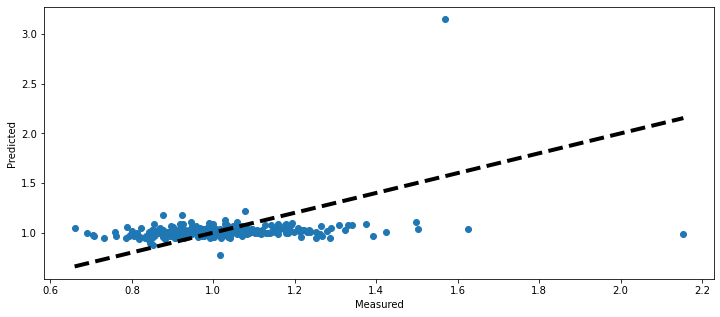

In [567]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

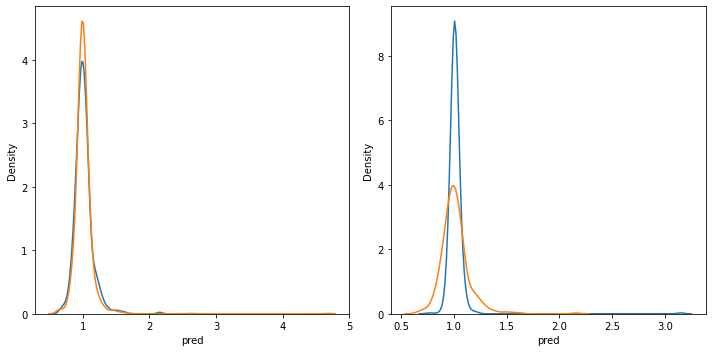

In [568]:
import seaborn as sns
# Hacemos las predicciones y evaluamos los resultados graficamente, tanto en el set de Train como de Test
y_test_pred = y_pred
y_train_pred = y_test

test = y_test
train = y_train

res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot = sns.kdeplot(res_df_train['pred'], ax=axes[0])
plot = sns.kdeplot(res_df_train['test'], ax=axes[0])
plot = sns.kdeplot(res_df_test['pred'], ax=axes[1])
plot = sns.kdeplot(res_df_test['test'], ax=axes[1])
fig.tight_layout()

In [569]:
mae_test = np.round(res_df_test['dif_abs'].mean(),2)
gae_test = np.round(res_df_test['dif_abs'].sum(),2)
error_test_rate_abs = np.round(100*gae_test/res_df_test['test'].sum(),2)
error_test = np.round(res_df_test['dif'].sum(),2)
error_test_rate = np.round(100*error_test/res_df_test['test'].sum(),2)
print('El error absoluto medio es: ', mae_test)
print('El error global es: ', error_test)
print('La tasa de error global es: %',error_test_rate)

El error absoluto medio es:  0.09
El error global es:  1.1
La tasa de error global es: % 0.26


In [570]:
#res_df_test['pred'] = res_df_test['pred'].apply(lambda x : x if x > 0 else 0)

In [577]:
res_df_test.sort_values('dif%')

,pred,test,dif,dif_abs,dif%
638,0.987636,2.154215,-1.17,1.17,-54.15
633,1.041645,1.625013,-0.58,0.58,-35.90
108,1.036077,1.502079,-0.47,0.47,-31.02
803,0.969356,1.392315,-0.42,0.42,-30.38
110,1.008298,1.423548,-0.42,0.42,-29.17
...,...,...,...,...,...
1504,0.963529,0.705775,0.26,0.26,36.52
204,0.976764,0.705235,0.27,0.27,38.50
1456,0.995901,0.688645,0.31,0.31,44.62
641,1.042848,0.659345,0.38,0.38,58.16


In [584]:
np.abs(res_df_test['dif%']).mean()

8.56628297362111

In [579]:
df['Excess mortality P-scores, all ages'].describe()

KeyError: 'Excess mortality P-scores, all ages'

## Feature importance 

In [580]:
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree

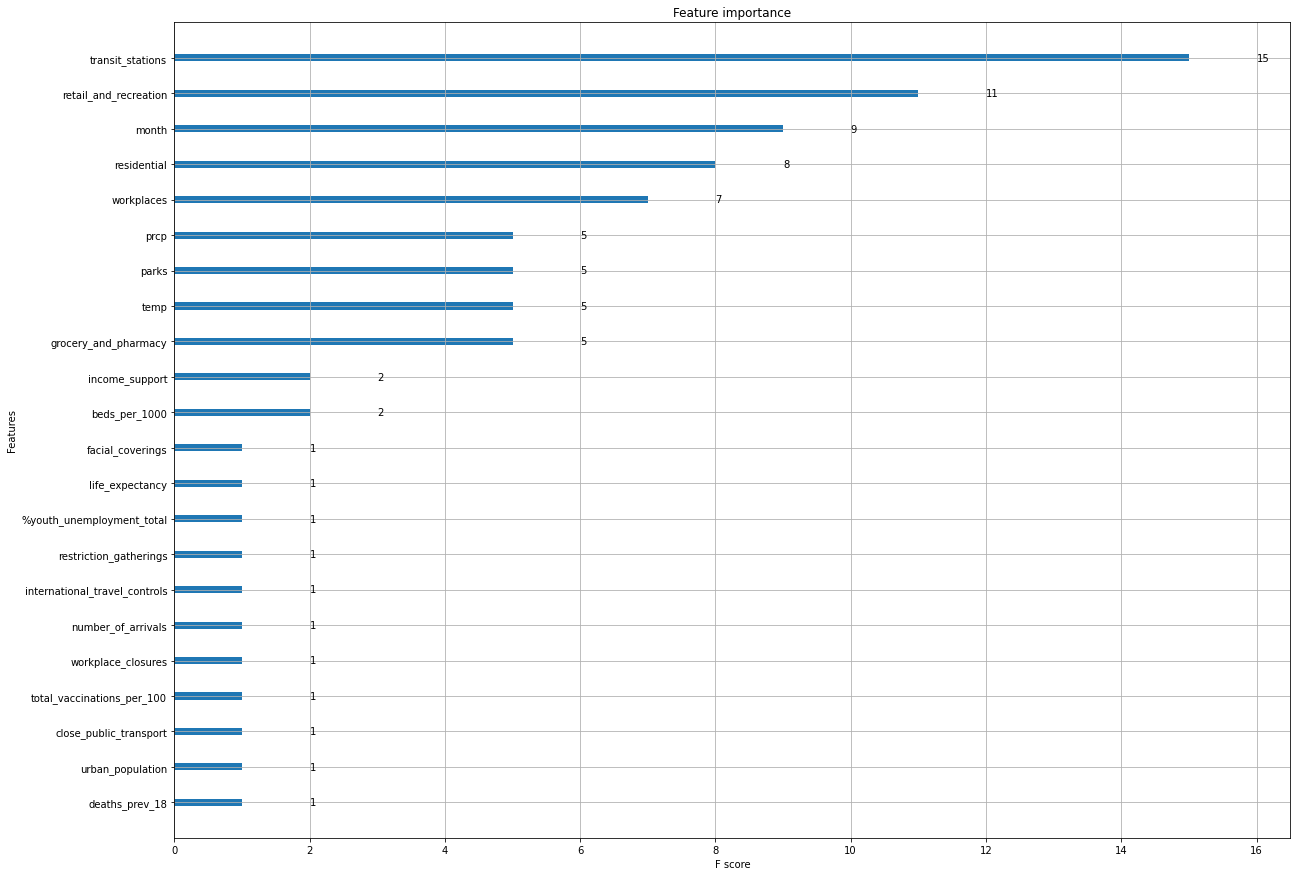

In [582]:
xgboost.plot_importance(grid.best_estimator_)
plt.rcParams['figure.figsize'] = [20, 15]
plt.show()